# Read data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F

In [2]:
! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_09_embeddings_and_seq2seq/names -O names

--2023-06-28 08:45:24--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_09_embeddings_and_seq2seq/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names’

names               100%[===================>]  54.56K  --.-KB/s    in 0.002s  

2023-06-28 08:45:24 (33.0 MB/s) - ‘names’ saved [55868/55868]



In [3]:
import os
start_token = " " # add space as a start token

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line for line in names]

In [4]:
print('Samples = ',len(names))
for x in names[::1500]:
    print(x)

Samples =  7944
 Abagael
 Eilis
 Liliane
 Stacy
 Giovanne
 Tann


The longest name =  16


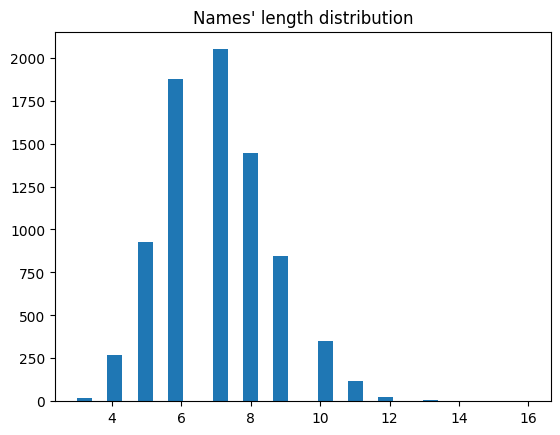

In [5]:
MAX_LENGTH = max(map(len, names))
print("The longest name = ", MAX_LENGTH)

plt.hist(list(map(len, names)), bins = 30)
plt.title("Names' length distribution")
plt.show()

# Text preprocessing

Соберём словарь всех уникальных букв, используемых в именах

In [6]:
tokens = set()

for name in names:
  tokens.update(set(name))

tokens = list(tokens)

vocab_volume = len(tokens)
print("Number of tokens:", vocab_volume)
print(tokens)

Number of tokens: 55
['f', 'u', 'z', 'v', 'V', 'E', 'U', 'q', 'J', 'T', 'r', 'i', 'n', ' ', 'd', 'Y', 'e', 'g', 'l', 'h', 'R', 'Q', 't', 'N', "'", 'B', 'w', 'o', 'a', 'A', 'j', 'D', 's', 'S', 'm', 'k', 'O', 'Z', 'I', 'P', 'W', 'M', 'X', '-', 'H', 'K', 'b', 'C', 'G', 'L', 'p', 'F', 'y', 'x', 'c']


Создадим словарь индекс - буква

In [7]:
token_dict = {token: idx for idx, token in enumerate(tokens)}

print(token_dict)

{'f': 0, 'u': 1, 'z': 2, 'v': 3, 'V': 4, 'E': 5, 'U': 6, 'q': 7, 'J': 8, 'T': 9, 'r': 10, 'i': 11, 'n': 12, ' ': 13, 'd': 14, 'Y': 15, 'e': 16, 'g': 17, 'l': 18, 'h': 19, 'R': 20, 'Q': 21, 't': 22, 'N': 23, "'": 24, 'B': 25, 'w': 26, 'o': 27, 'a': 28, 'A': 29, 'j': 30, 'D': 31, 's': 32, 'S': 33, 'm': 34, 'k': 35, 'O': 36, 'Z': 37, 'I': 38, 'P': 39, 'W': 40, 'M': 41, 'X': 42, '-': 43, 'H': 44, 'K': 45, 'b': 46, 'C': 47, 'G': 48, 'L': 49, 'p': 50, 'F': 51, 'y': 52, 'x': 53, 'c': 54}


In [8]:
def convert_to_matrix(names, max_length=None,
                      pad=token_dict[' '], dtype='int32', batch_first=True):

  max_length = max_length or max(map(len, names))
  names_idx = np.zeros([len(names), max_length], dtype) + pad # matrix batch_size * max_len of nulls

  for i in range(len(names)):
    line_idx = [token_dict[item] for item in names[i]]
    names_idx[i, :len(line_idx)] = line_idx

  if not batch_first:
    names_idx = np.transpose(names_idx)

  return names_idx

In [9]:
print('\n'.join(names[::1000]))

 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


In [10]:
print(convert_to_matrix(names[::1000]))

[[13 29 46 28 17 28 16 18 13]
 [13 47 18 28 10 16 32 22 28]
 [13 48 18 27 10 52 13 13 13]
 [13 49 11 18 11 28 12 16 13]
 [13 39 10 11 32 32 11 16 13]
 [13 48 16 16 22 28 13 13 13]
 [13 48 11 27  3 28 12 12 16]
 [13 39 11 17 17 52 13 13 13]]


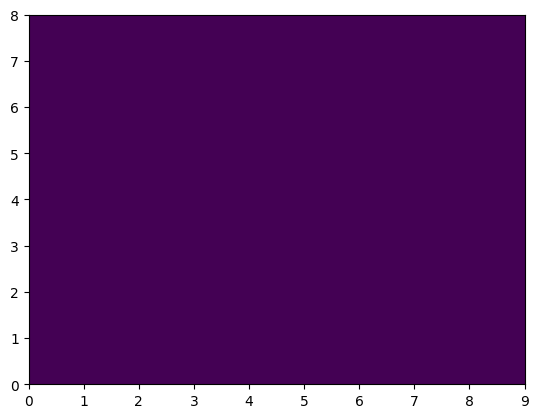

In [11]:
plt.pcolormesh(convert_to_matrix(names[::1000]) == 25)
plt.show()

In [12]:
''.join([tokens[idx] for idx in convert_to_matrix(names[::1000])[0]])

' Abagael '

# Implementation

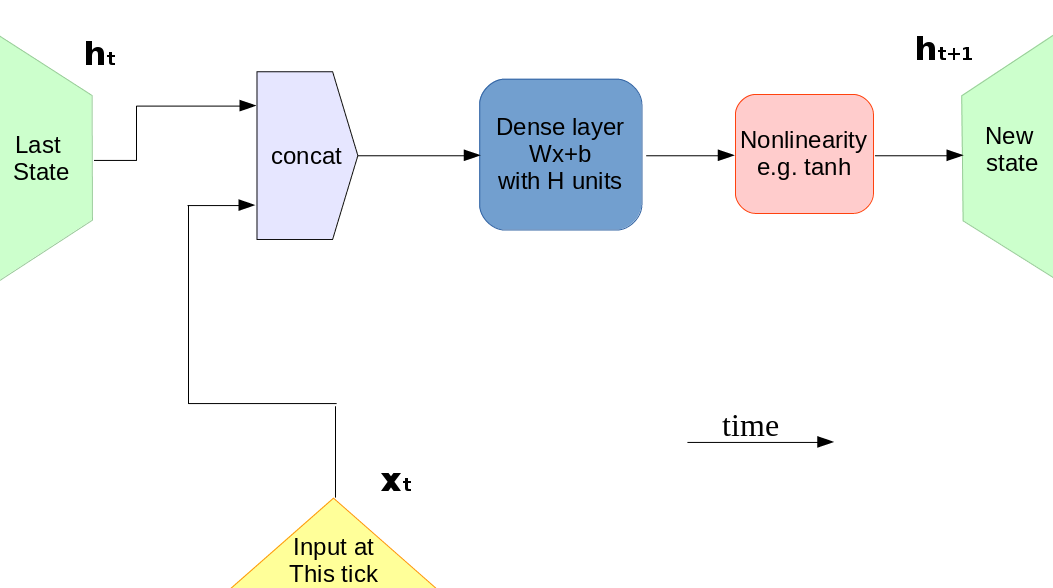

In [13]:
embedding = nn.Embedding(5, 5)

In [14]:
next(iter(embedding.parameters()))

Parameter containing:
tensor([[-0.0899,  0.3318,  0.6739, -0.1233, -0.1138],
        [ 1.6749,  0.7737,  0.2743, -0.0114, -0.9886],
        [-0.2220,  1.5685, -0.1560, -0.3007,  1.5942],
        [-0.8543,  1.9751,  0.4809,  1.6553,  0.0676],
        [ 0.0204, -2.1559, -1.2129,  0.3408, -1.0586]], requires_grad=True)

In [15]:
class RNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):

        # get vector embedding of x
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [16]:
rnn = RNNCell()
criterion = nn.CrossEntropyLoss()

Training cycle

In [17]:
def rnn_cycle(rnn, batch_idx):

    batch_size, max_length = batch_idx.size()
    hidden_state = rnn.initial_state(batch_size)
    probas = []

    for item in batch_idx.transpose(0, 1):

        hidden_state, logits = rnn(item, hidden_state)
        probas.append(logits)

    return torch.stack(probas, dim=1)

Check if OK

In [18]:
batch_idx = convert_to_matrix(names[:5])
batch_idx = torch.tensor(batch_idx, dtype=torch.int64)

prob_seq = rnn_cycle(rnn, batch_idx)

In [19]:
preds = prob_seq[:, :-1]

next_token = batch_idx[:, 1:]

loss = criterion(
    preds.contiguous().view(-1, vocab_volume),
    next_token.contiguous().view(-1)
)

loss.backward()

# Training

### TryCrossEntropyLoss

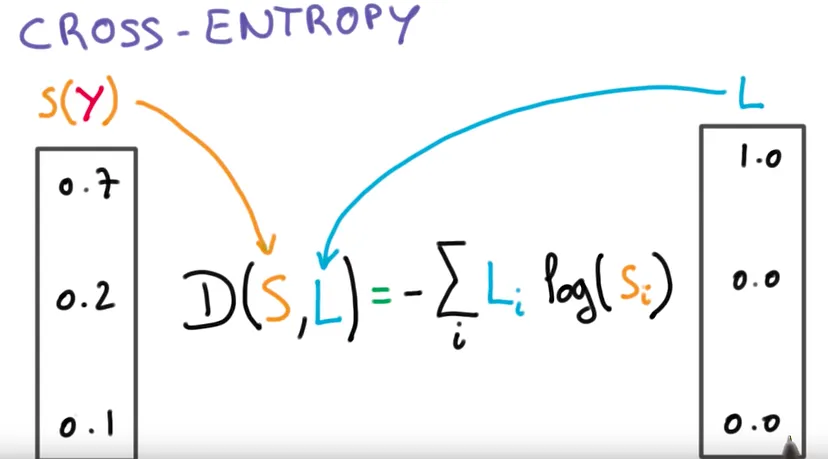

In [20]:
from IPython.display import clear_output
from random import sample

In [21]:
rnn_ce = RNNCell()
opt = torch.optim.Adam(rnn_ce.parameters())
history = []

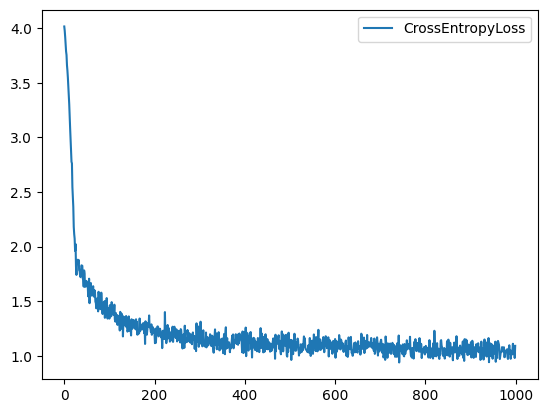

In [22]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()

    batch_ix = convert_to_matrix(sample(names, 32), max_length=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    probs_seq = rnn_cycle(rnn_ce, batch_ix)

    # compute loss
    preds = probs_seq[:, :-1]
    next_token = batch_ix[:, 1:]

    loss = criterion(
      preds.reshape((-1, vocab_volume)),
      next_token.reshape(-1)
    )
    loss.backward()
    opt.step()

    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='CrossEntropyLoss')
        plt.legend()
        plt.show()

# Try NLLLoss

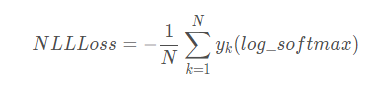

In [23]:
def rnn_cycle(rnn, batch_idx):

    batch_size, max_length = batch_idx.size()
    hidden_state = rnn.initial_state(batch_size)
    probas = []

    for item in batch_idx.transpose(0, 1):

        hidden_state, logits = rnn(item, hidden_state)
        probas.append(F.log_softmax(logits, -1))

    return torch.stack(probas, dim=1)

In [24]:
criterion = nn.NLLLoss()
rnn_nll = RNNCell()
opt = torch.optim.Adam(rnn_nll.parameters())
history = []

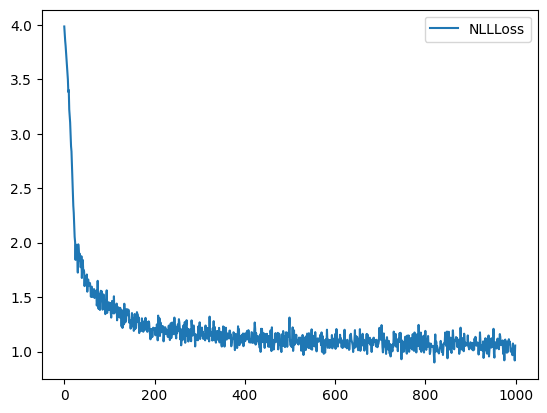

In [25]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()

    batch_ix = convert_to_matrix(sample(names, 32), max_length=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    probs_seq = rnn_cycle(rnn_nll, batch_ix)

    # compute loss
    preds = probs_seq[:, :-1]
    next_token = batch_ix[:, 1:]

    loss = criterion(
      preds.reshape((-1, vocab_volume)),
      next_token.reshape(-1)
    )
    loss.backward()
    opt.step()

    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='NLLLoss')
        plt.legend()
        plt.show()

# Generation

In [26]:
def generate(rnn, start_phrase = ' ', max_length = MAX_LENGTH, temp = 1.0):

    x_seq = [token_dict[token] for token in start_phrase]
    x_seq = torch.tensor([x_seq], dtype = torch.int64)
    hidden_state = rnn.initial_state(batch_size=1)

    # if start_phrase:
    for i in range(len(start_phrase) - 1):
        hidden_state, _ = rnn(x_seq[:, i], hidden_state)

    # generation
    for _ in range(max_length - len(start_phrase)):
        hidden_state, logits = rnn(x_seq[:, -1], hidden_state)
        next = F.softmax(logits/temp, dim = 1).data.numpy()[0]

        # sample next token and push it to sequence
        next_idx = np.random.choice(vocab_volume, p = next)
        next_idx = torch.tensor([[next_idx]], dtype = torch.int64)
        x_seq = torch.cat([x_seq, next_idx], dim = 1)

    return ''.join(tokens[idx] for idx in x_seq.data.numpy()[0])

With CrossEntropyLoss

In [27]:
for _ in range(10):
    print(generate(rnn_ce, temp = 0.5))

 Shorrie        
 Nelin          
 Mary           
 Wistere        
 Able           
 Alanda         
 Celica         
 Canelle        
 Beria          
 Basten         


In [28]:
for _ in range(10):
    print(generate(rnn_ce, start_phrase = 'Al', temp = 0.6))

Altycel         
Alline          
Allelin         
Allinna         
Allannce        
Aldy            
Alisa           
Aly             
Alvan           
Alinnel         


With NLL

In [29]:
for _ in range(10):
    print(generate(rnn_nll, temp = 0.5))

 Sherie         
 Malbe          
 Tisera         
 Karana         
 Areste         
 Carin          
 Belene         
 Torine         
 Arey           
 Alda           


In [30]:
for _ in range(10):
    print(generate(rnn_nll, start_phrase = 'Al', temp = 0.5))

Alson           
Allin           
Alberle         
Allan           
Allenda         
Aley            
Allan           
Allin           
Allee           
Albella         


# Try torch.rnn

In [31]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=vocab_volume, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [32]:
batch_ix = convert_to_matrix(sample(names, 32), max_length=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logp_seq = model(batch_ix)

loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, vocab_volume),
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

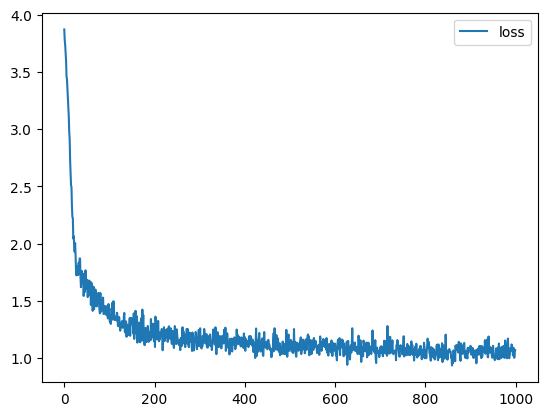

In [33]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()

    batch_ix = convert_to_matrix(sample(names, 32), max_length=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    probs_seq = model(batch_ix)

    # compute loss
    preds = probs_seq[:, :-1]
    next_token = batch_ix[:, 1:]

    loss = F.nll_loss(
      preds.reshape((-1, vocab_volume)),
      next_token.reshape(-1)
    )
    loss.backward()
    opt.step()

    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()